# Mempool Data preprocessing to JSON array 

In [32]:
import json 
import os.path
import matplotlib.pyplot as plt
from types import SimpleNamespace

FIRST_BLOCK_HEIGHT_DURING_CONGESTION = 498084 
FIRST_BLOCK_NO_CONGESTION = 716644

MEMPOOL_DIR_DURING_CONGESTION = "mempool-during-congestion"
MEMPOOL_DIR_NO_CONGESTION = "mempool-no-congestion"

# Edges crossed by the Max-Cut (LWMC), computed with the weighted imbalanced-max-cut Greedy procedure, 
# with data obtained on May 5, 2022

MAX_CUT_SIZE = 58531 
MAX_CUT_CAPACITY = 2464.37 # Weighted [BTCs]

AVERAGE_LND_CLOSING_CHANNEL_DELAY = 529

# We read the JSON file containing blocks data (height, number of transactions)

blocks_file = open(f"blocks/blocks.json", mode = 'r')
blocks_data_content = blocks_file.read()
blocks_data = json.loads(blocks_data_content)

# We read the file containing mempool historical data

FIRST_BLOCK_HEIGHT = FIRST_BLOCK_HEIGHT_DURING_CONGESTION
MEMPOOL_DIR = MEMPOOL_DIR_DURING_CONGESTION

# FIRST_BLOCK_HEIGHT = FIRST_BLOCK_NO_CONGESTION
# MEMPOOL_DIR = MEMPOOL_DIR_NO_CONGESTION

i = 1
mempool_data_json_string = ''

while os.path.exists(f"{MEMPOOL_DIR}/{i}_mempool"):
    mempool_data_file = open(f"{MEMPOOL_DIR}/{i}_mempool", mode = 'r')
    mempool_data_content = mempool_data_file.read()
    
    # We replace call() from file content (it is used for the website to load the JSONP)
    mempool_data_content = mempool_data_content[5 : len(mempool_data_content) - 2]
    
    # I remove the first and the last square brackets, then I will add them again at the end before parsing the JSON,
    # in order to obtain a single merged json of all the mempool data
    mempool_data_content = mempool_data_content[1:]
    mempool_data_content = mempool_data_content[:-1]

    mempool_data_content += ','

    mempool_data_json_string += mempool_data_content
    mempool_data_file.close()

    i += 1

mempool_data_json_string = mempool_data_json_string[:-1]
mempool_data_json_string = f"[{mempool_data_json_string}]"

# Parsing JSON file

mempool_data = json.loads(mempool_data_json_string) 

# Mass Double Spend Attack Simulation using mempool historical data

In [33]:
# Data taken from https://jochen-hoenicke.de/queue/#BTC,all,count

PROBLEMATIC_INTERVALS = [[1516728783, 1516729440], [1515943500, 1515944160]] # problematic intervals that should not be considerated (probably the BTC nodes of the owner went offline for a while)

fee_ranges = [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 17, 20, 25, 30, 40, 50, 60, 70, 80, 100, 120, 140, 170, 200, 250, 300, 400, 500, 600, 700, 800, 1000, 1200, 1400, 1700, 2000, 2500, 3000, 4000, 5000, 6000, 7000, 8000, 10000 ]

# There will be `num_zombie_channels` to be` * 2 transactions to be confirmed (attacker txs and justice txs)
def simulate(mempool_data, blocks_data, first_block_height, fee_index_attacker, num_channels, ln_closing_channel_delay, highest_priority=False, dynamic=False, beta=1.01, step=1):
    
    first_height = blocks_data[0]["height"] # First Block Height in our dataset
    blocksCounter = 0
    last_total_tx_count = None
    last_tx_count_per_fee_level = None
    remaining_attacker_txs = num_channels # Attacker txs that are still unconfirmed
    num_confirmed_victim_transactions = 0

    victim_index = 0   # Index in the `transactions` array
    transactions = []  # Array of SimpleNamespace (JavaScript-like objects): contains all the LN victim transactions

    for i in range(0, num_channels):
        transaction = SimpleNamespace()
        transaction.submitted = False
        transaction.confirmed = False
        transaction.confirmedBlockNumber = -1
        transaction.attackerTxConfirmedBlockNumber = -1
        transaction.fee_index = -1
        transaction.current_fee = -1
        transaction.tx_with_same_fee = -1 # Transactions already present in the mempool at the moment of submission with the same fee level
        transaction.isAttacker = False
        transactions.append(transaction) 
    
    # For each LN tx, we associate the "position" among the other txs with the same fee 
    # (how many transactions with the same fee were already in the mempool when the tx was inserted)
    ln_txs_per_fee_level = []  
    for i in range(len(fee_ranges)):
        empty_array = []
        ln_txs_per_fee_level.append(empty_array)
    
    # When we confirm any LN tx, it means that it "replaces" a transaction that was historically confirmed, and thus removed
    # from the mempool. Therefore, we must keep track and include them in a later block.
    tx_to_be_added = [0] * len(fee_ranges) 

    for snapshot in mempool_data:
        timestamp = snapshot[0]
        tx_count_per_fee_level = snapshot[1]
        total_tx_count = sum(tx_count_per_fee_level)

        if last_total_tx_count is None and last_tx_count_per_fee_level is None:
            last_total_tx_count = total_tx_count
            last_tx_count_per_fee_level = tx_count_per_fee_level

            initial_tx_with_same_fee_attacker = 0
            if not highest_priority:
                initial_tx_with_same_fee_attacker = tx_count_per_fee_level[fee_index_attacker]

            attackerTx = SimpleNamespace()
            attackerTx.fee_index = fee_index_attacker
            attackerTx.tx_with_same_fee = initial_tx_with_same_fee_attacker
            attackerTx.isAttacker = True 
            attackerTx.confirmed = False 

            ln_txs_per_fee_level[fee_index_attacker].append(attackerTx)
            continue
        
        # "Problematic" intervals are intervals in which probably the node of the owner of the website that gives the dataset
        # went offline for sometime
        is_in_problematic_interval = isInProblematicInterval(timestamp, PROBLEMATIC_INTERVALS)

        if total_tx_count < last_total_tx_count and not is_in_problematic_interval:
            # New Block

            # On new block, we compute the number of transactions with a fee that is higher than LN txs
            # If this number is higher than the number of transactions in the block, no LN txs are confirmed in this block.
            # Otherwise, some LN txs could be included in the block, and we must check their current "position" in the mempool
            # at their fee level, i.e. how many txs there are in the same fee level that were submitted before them.

            blocksCounter += 1
            
            num_tx_in_block = blocks_data[(first_block_height - first_height + blocksCounter) - 1]["n_transactions"]
            
            # As said before, LN txs actually "replace" standard txs that would have been removed from the mempool
            # without LN txs, therefore they must be re-added and considered for future blocks.
            amount_tx_to_be_added = 0
            starting_index_tx_to_be_added = 0

            # We find the higher fee in LN transactions
            highest_ln_fee_index = 0
            i = len(fee_ranges) - 1
            while i >= 0:
                if len(ln_txs_per_fee_level[i]) > 0:
                    highest_ln_fee_index = i
                    break
                i -= 1

            index = len(last_tx_count_per_fee_level) - 1
            tx_with_higher_fee = 0

            # Now we confirm transactions that have an higher fee than our LN txs
            while index > highest_ln_fee_index and tx_with_higher_fee < num_tx_in_block:
                tmp = tx_with_higher_fee
                tx_with_higher_fee = tx_with_higher_fee + last_tx_count_per_fee_level[index] + tx_to_be_added[index]

                # Here we don't call decreaseTxWithSameFee because there are no LN txs in this fee level
                # by construction (fee_index > highest_ln_fee_index)

                tx_to_be_added[index] = max(tx_to_be_added[index] - (num_tx_in_block - tmp), 0) # (num_tx_in_block - tmp) is the number of txs with this fee level included in this block   
                index -= 1

            tx_to_be_confirmed = num_tx_in_block - tx_with_higher_fee

            if tx_to_be_confirmed > 0:
                
                # We put None placeholder values in the `ln_txs_per_fee_level` array to remove confirmed ln txs after
                # all the txs that are included in the block are computed, therefore the None txs must not be taken into
                # consideration when we compute the average fee for new victim transactions. Using `filter` on None values
                # slows down too much the simulation, thus it's more efficient to keep track of the number of None values
                # for each fee level and then subtracting their number when needed.
                none_txs_per_fee_level = [0] * len(fee_ranges)

                # There is still "space" for more transactions in the block
            
                fee_index = highest_ln_fee_index
                
                while fee_index >= 0 and tx_to_be_confirmed > 0:
                    
                    ln_txs = ln_txs_per_fee_level[fee_index]

                    if len(ln_txs) > 0: # If there are LN txs in this fee level
                        tx_index = 0

                        while tx_index < len(ln_txs) and tx_to_be_confirmed > 0:
                            tx = ln_txs_per_fee_level[fee_index][tx_index]

                            if not tx.isAttacker and tx.attackerTxConfirmedBlockNumber == blocksCounter:
                                # The corresponding attacker tx was confirmed in this block, therefore we cannot
                                # confirm this victim tx in this fee level
                                tx_index += 1
                                continue
                            
                            # The "position" of txs in the mempool is modified
                            if tx.tx_with_same_fee >= tx_to_be_confirmed:
                                decreaseTxWithSameFee(fee_index, ln_txs_per_fee_level, tx_to_be_added, tx_to_be_confirmed)
                                tx_to_be_confirmed = 0
                            else:
                                if tx.tx_with_same_fee > 0:
                                    tx_to_be_confirmed -= tx.tx_with_same_fee
                                    decreaseTxWithSameFee(fee_index, ln_txs_per_fee_level, tx_to_be_added, tx.tx_with_same_fee)
                            
                            # if(tx_to_be_confirmed == 0):
                            #     break

                            if tx.isAttacker:
                                tmp = remaining_attacker_txs
                                remaining_attacker_txs = max(remaining_attacker_txs - tx_to_be_confirmed, 0)
                                num_attacker_confirmed_txs = tmp - remaining_attacker_txs
                                tx_to_be_confirmed -= num_attacker_confirmed_txs
                                amount_tx_to_be_added += num_attacker_confirmed_txs
                                starting_index_tx_to_be_added = fee_index
                                new_victim_index = victim_index + num_attacker_confirmed_txs

                                while victim_index < new_victim_index:
                                    transactions[victim_index].submitted = True
                                    victim_fee_index, victim_fee = get_average_fee(getFullTxCountPerFeeLevel(tx_count_per_fee_level, ln_txs_per_fee_level, tx_to_be_added, remaining_attacker_txs, none_txs_per_fee_level)) # average or median
                                    transactions[victim_index].fee_index = victim_fee_index
                                    transactions[victim_index].current_fee = victim_fee
                                    transactions[victim_index].tx_with_same_fee = tx_count_per_fee_level[victim_fee_index] + tx_to_be_added[victim_fee_index] 
                                    transactions[victim_index].attackerTxConfirmedBlockNumber = blocksCounter
                                    ln_txs_per_fee_level[victim_fee_index].append(transactions[victim_index])
                                    victim_index += 1

                                if remaining_attacker_txs == 0:
                                    print("Finished mining attacker txs at block:", blocksCounter)
                                    ln_txs_per_fee_level[fee_index][tx_index] = None
                                    none_txs_per_fee_level[fee_index] += 1
                            else:
                                tx.confirmed = True
                                tx.confirmedBlockNumber = blocksCounter
                                tx_to_be_confirmed -= 1
                                num_confirmed_victim_transactions += 1   
                                ln_txs_per_fee_level[fee_index][tx_index] = None
                                none_txs_per_fee_level[fee_index] += 1
                                amount_tx_to_be_added += 1
                                starting_index_tx_to_be_added = fee_index

                            tx_index += 1

                    else:
                        tmp = tx_to_be_confirmed
                        tx_to_be_confirmed = max(tx_to_be_confirmed - tx_to_be_added[fee_index], 0)
                        tx_to_be_added[fee_index] = max(tx_to_be_added[fee_index] - (tmp - tx_to_be_confirmed), 0)
                        tx_to_be_confirmed = max(tx_to_be_confirmed - last_tx_count_per_fee_level[fee_index], 0)
                    
                    fee_index -= 1
                

                for i in range(len(ln_txs_per_fee_level)):
                    ln_txs_per_fee_level[i] = list(filter(lambda tx: tx is not None, ln_txs_per_fee_level[i]))
                    
            # If there are some `tx_to_be_added` to add, they are added to the corresponding fee_level in the array
            find_txs_to_be_added(starting_index_tx_to_be_added, amount_tx_to_be_added, last_tx_count_per_fee_level, tx_to_be_added)

            if dynamic and blocksCounter % step == 0 and victim_index > 0:
                tx_to_be_removed = []
                tx_to_be_added_dynamically = []

                for i in range(len(fee_ranges)):
                    empty_array = []
                    tx_to_be_removed.append(empty_array)

                for i in range(len(fee_ranges)):
                    empty_array = []
                    tx_to_be_added_dynamically.append(empty_array)    

                for fee_index in range(len(ln_txs_per_fee_level)):
                    for tx_index in range(len(ln_txs_per_fee_level[fee_index])):
                        tx = ln_txs_per_fee_level[fee_index][tx_index]
                        if tx.confirmed or tx.isAttacker or tx.attackerTxConfirmedBlockNumber == blocksCounter: # TODO: should attacker use RBF?
                            continue
                        new_fee = tx.current_fee * beta
                        tx.current_fee = new_fee
                        new_fee_index = find_index_of_fee_in_ranges(new_fee)

                        if new_fee_index != tx.fee_index:
                            tx.fee_index = new_fee_index
                            tx.tx_with_same_fee = tx_count_per_fee_level[new_fee_index] + tx_to_be_added[new_fee_index] 
                            ln_txs_per_fee_level[fee_index][tx_index] = None
                            tx_to_be_removed[fee_index].append(tx_index)
                            tx_to_be_added_dynamically[new_fee_index].append(tx)

                for i in range(len(ln_txs_per_fee_level)):
                    ln_txs_per_fee_level[i] = list(filter(lambda tx: tx is not None, ln_txs_per_fee_level[i]))

                for txs in tx_to_be_added_dynamically:
                    for tx in txs:
                        ln_txs_per_fee_level[tx.fee_index].append(tx)

        # TODO: could only run the simulation until N + `ln_closing_channel_delay` blocks has passed, with n that is the number of confirmation block of the last attacker tx
        # a thing to consider is that, if no congestion (num tx in mempool less than the max number of tx in block) then we have to avoid considering num_tx_in_block
        if num_confirmed_victim_transactions >= num_channels: 
            
            print("Finished at block ", blocksCounter)

            channels_not_able_to_close = 0
            for tx in transactions:
                #print(tx.fee_index)
                if (tx.confirmedBlockNumber - tx.attackerTxConfirmedBlockNumber) > ln_closing_channel_delay: 
                    channels_not_able_to_close += 1
            print("Channels not able to close in time: ", channels_not_able_to_close)
            return channels_not_able_to_close

        last_total_tx_count = total_tx_count
        last_tx_count_per_fee_level = tx_count_per_fee_level
    
    print("Not able to finish within the simulation time frame")
    return None


def find_index_of_fee_in_ranges(fee):
    fee_index = 0
    i = 1
    while i < len(fee_ranges):
        if fee_ranges[i-1] <= fee and fee < fee_ranges[i]:
            fee_index = i-1
            return fee_index
        i = i + 1
    return len(fee_ranges) - 1

def get_average_fee(tx_count_per_fee_level):
    total_tx_count = sum(tx_count_per_fee_level)
    acc = 0
    i = 0
    while i < len(tx_count_per_fee_level):
        acc = acc + (fee_ranges[i] * tx_count_per_fee_level[i])
        i = i + 1
    avg_fee = acc / total_tx_count
    average_index = find_index_of_fee_in_ranges(avg_fee)
    return average_index, avg_fee

def get_median_index_fee(tx_count_per_fee_level):
    total_tx_count = sum(tx_count_per_fee_level)

    # Computing the index of the median fee in `fee_ranges` (in the first snapshot of the simulation)

    acc = 0
    i = 0
    median_index = 0
    for c in tx_count_per_fee_level:
        acc = acc + c
        if acc >= total_tx_count / 2:
            # As soon as we detect that half of all the txs in the mempool have a lower fee 
            # than the current fee index (and half have an higher fee), than this is the median fee index
            median_index = i
            break
        else:
            i = i + 1  
    return median_index    

def isInProblematicInterval(timestamp, PROBLEMATIC_INTERVALS):
    for interval in PROBLEMATIC_INTERVALS:
        if timestamp >= interval[0] and timestamp < interval[1]:
            return True
    return False

def decreaseTxWithSameFee(fee_index, ln_txs_per_fee_level, tx_to_be_added, amount):
    
    tx_to_be_added[fee_index] = max(tx_to_be_added[fee_index] - amount, 0)

    for tx in list(filter(lambda tx: tx is not None, ln_txs_per_fee_level[fee_index])):
        tx.tx_with_same_fee = max(tx.tx_with_same_fee - amount, 0)
    
def getFullTxCountPerFeeLevel(tx_count_per_fee_level, ln_txs_per_fee_level, tx_to_be_added, remaining_attacker_txs, none_txs_per_fee_level):
    full_tx_count_per_fee_level = [0] * len(fee_ranges)
    
    ###### Using filter here slows down the simulation, so we have to use `none_txs_per_fee_level` 
    #ln_txs_per_fee_level_filtered2 = [0] * len(fee_ranges)
    #for i in range(len(ln_txs_per_fee_level)):
        #ln_txs_per_fee_level_filtered2[i] = list(filter(lambda tx: tx is not None, ln_txs_per_fee_level[i]))
    #####
    
    for i in range(len(fee_ranges)):
        full_tx_count_per_fee_level[i] += tx_count_per_fee_level[i] + tx_to_be_added[i]

        if len(ln_txs_per_fee_level[i]) > 0:
            if ln_txs_per_fee_level[i][0] is not None and ln_txs_per_fee_level[i][0].isAttacker:
                full_tx_count_per_fee_level[i] += remaining_attacker_txs + ((len(ln_txs_per_fee_level[i]) - 1) - none_txs_per_fee_level[i])
            else:
                full_tx_count_per_fee_level[i] += (len(ln_txs_per_fee_level[i]) - none_txs_per_fee_level[i])

    return full_tx_count_per_fee_level
            
def find_txs_to_be_added(starting_fee_index, amount, last_tx_count_per_fee_level, tx_to_be_added):
    index = starting_fee_index

    while amount > 0 and index >= 0:
        if(last_tx_count_per_fee_level[index] >= amount):
            tx_to_be_added[index] += amount
            amount = 0
        else:
            tx_to_be_added[index] += last_tx_count_per_fee_level[index]
            amount -= last_tx_count_per_fee_level[index]
        index -= 1

# Number of justice transactions that are not able to be confirmed before the to_self_delay as a function of the fee used by the attacker or various values of to_self_delay with static honest player strategy (attacking the total LWMC)

to_self_delay: 100 blocks
Finished mining attacker txs at block: 7459
Finished at block  7741
Channels not able to close in time:  58531
Finished mining attacker txs at block: 7429
Finished at block  7714
Channels not able to close in time:  58531
Finished mining attacker txs at block: 7367
Finished at block  7624
Channels not able to close in time:  58531
Finished mining attacker txs at block: 7130
Finished at block  7490
Channels not able to close in time:  58531
Finished mining attacker txs at block: 6959
Finished at block  7456
Channels not able to close in time:  58531
Finished mining attacker txs at block: 6836
Finished at block  7372
Channels not able to close in time:  58531
Finished mining attacker txs at block: 3826
Finished at block  7147
Channels not able to close in time:  58531
Finished mining attacker txs at block: 3727
Finished at block  7132
Channels not able to close in time:  58531
Finished mining attacker txs at block: 1617
Finished at block  6992
Channels not able 

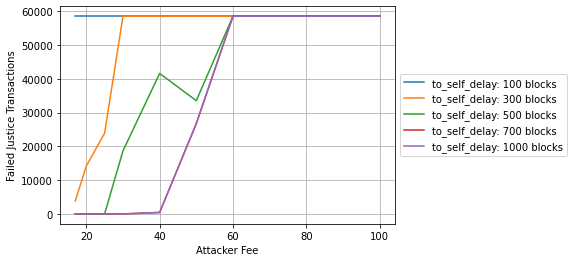

In [34]:
ln_delays = [100, 300, 500, 700, 1000]
labels = []

fig, ax = plt.subplots()
ax.grid(True)

for ln_delay in ln_delays:
    print(f"to_self_delay: {ln_delay} blocks")
    y = []
    x = []

    i = 12
    fee_ranges2 = [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 17, 20, 25, 30, 40, 50, 60, 70, 80, 100 ]
    while(i < len(fee_ranges2)):
        n = simulate(mempool_data, blocks_data, FIRST_BLOCK_HEIGHT, i, MAX_CUT_SIZE, ln_delay)
        y.append(n)
        x.append(fee_ranges2[i])
        i += 1
    
    plt.plot(x, y)   
    labels.append(f"to_self_delay: {ln_delay} blocks") 

plt.xlabel('Attacker Fee') 
plt.ylabel(f'Failed Justice Transactions')
plt.legend(labels=labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Number of justice transactions that are not able to be confirmed before the to_self_delay as a function of attacker fee with dynamic honest player strategy, for various values of the step parameter (attacking the total LWMC)

Step: 1
Finished mining attacker txs at block: 7487
Finished at block  7576
Channels not able to close in time:  0
Finished mining attacker txs at block: 7482
Finished at block  7549
Channels not able to close in time:  0
Finished mining attacker txs at block: 7465
Finished at block  7542
Channels not able to close in time:  0
Finished mining attacker txs at block: 7350
Finished at block  7427
Channels not able to close in time:  0
Finished mining attacker txs at block: 7115
Finished at block  7203
Channels not able to close in time:  0
Finished mining attacker txs at block: 6843
Finished at block  6932
Channels not able to close in time:  0
Finished mining attacker txs at block: 6810
Finished at block  6872
Channels not able to close in time:  0
Finished mining attacker txs at block: 3766
Finished at block  3865
Channels not able to close in time:  0
Step: 5
Finished mining attacker txs at block: 7460
Finished at block  7653
Channels not able to close in time:  0
Finished mining attac

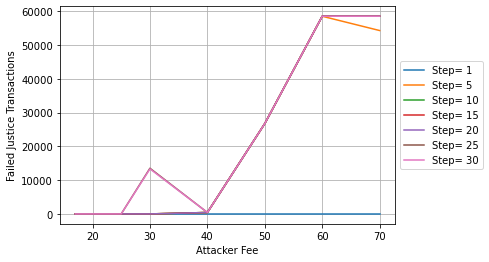

In [35]:
fig, ax = plt.subplots()
ax.grid(True)

labels = []
steps = [1, 5, 10, 15, 20, 25, 30] 
fee_ranges2 = [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 17, 20, 25, 30, 40, 50, 60, 70 ]

for step in steps:
    print(f"Step: {step}")
    x = []
    y = []
    i = 12
    while i < len(fee_ranges2):
        n = simulate(mempool_data, blocks_data, FIRST_BLOCK_HEIGHT, i, MAX_CUT_SIZE, AVERAGE_LND_CLOSING_CHANNEL_DELAY, dynamic=True, step=step)
        x.append(fee_ranges2[i])
        y.append(n)
        i += 1
    plt.plot(x, y)
    labels.append(f"Step= {step}") 
  
plt.xlabel('Attacker Fee') 
plt.ylabel(f'Failed Justice Transactions')
plt.legend(labels=labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Attacker profits as a function of the fee used by the attack in Scenario 1 (static and dynamic honest player strategy)

Finished mining attacker txs at block: 7357
Finished at block  7679
Channels not able to close in time:  0
Finished mining attacker txs at block: 7331
Finished at block  7627
Channels not able to close in time:  0
Finished mining attacker txs at block: 7165
Finished at block  7462
Channels not able to close in time:  0
Finished mining attacker txs at block: 6959
Finished at block  7399
Channels not able to close in time:  0
Finished mining attacker txs at block: 6858
Finished at block  7371
Channels not able to close in time:  427
Finished mining attacker txs at block: 3812
Finished at block  7348
Channels not able to close in time:  20084
Finished mining attacker txs at block: 3739
Finished at block  7159
Channels not able to close in time:  20084
Finished mining attacker txs at block: 1623
Finished at block  7132
Channels not able to close in time:  20084


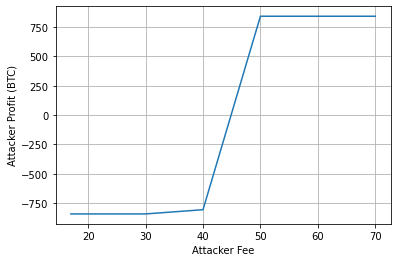

Step = 1
Finished mining attacker txs at block: 7379
Finished at block  7455
Channels not able to close in time:  0
Finished mining attacker txs at block: 7367
Finished at block  7437
Channels not able to close in time:  0
Finished mining attacker txs at block: 7165
Finished at block  7330
Channels not able to close in time:  0
Finished mining attacker txs at block: 6959
Finished at block  7044
Channels not able to close in time:  0
Finished mining attacker txs at block: 6858
Finished at block  6983
Channels not able to close in time:  0
Finished mining attacker txs at block: 3812
Finished at block  4092
Channels not able to close in time:  0
Finished mining attacker txs at block: 3743
Finished at block  3839
Channels not able to close in time:  0
Finished mining attacker txs at block: 1623
Finished at block  1780
Channels not able to close in time:  0
Step = 3
Finished mining attacker txs at block: 7357
Finished at block  7478
Channels not able to close in time:  0
Finished mining att

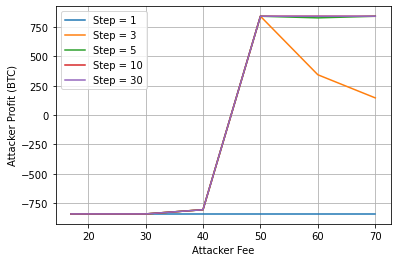

In [36]:
# Attacker Profit - Static Case

fig, ax = plt.subplots()
ax.grid(True)

attacked_fraction_of_max_cut = {
    "k" : 30,
    "edges" : 20084,
    "capacity" : 1685.13
}

# num_zombie_channels = MAX_CUT_SIZE
# capacity = MAX_CUT_CAPACITY

num_zombie_channels = attacked_fraction_of_max_cut["edges"]
capacity = attacked_fraction_of_max_cut["capacity"]

y = []
x = []

i = 12
fee_ranges2 = [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 17, 20, 25, 30, 40, 50, 60, 70 ]
avg_capacity_per_channel = capacity / num_zombie_channels

while(i < len(fee_ranges2)):
    failed_justice_transactions = simulate(mempool_data, blocks_data, FIRST_BLOCK_HEIGHT, i, num_zombie_channels, AVERAGE_LND_CLOSING_CHANNEL_DELAY)
    profit = 0.5 * failed_justice_transactions * avg_capacity_per_channel - (0.5 * (num_zombie_channels - failed_justice_transactions) * avg_capacity_per_channel)
    y.append(profit)
    x.append(fee_ranges2[i])
    i += 1

plt.plot(x, y)   

plt.xlabel('Attacker Fee') 
plt.ylabel(f'Attacker Profit (BTC)')
plt.show()

# Attacker Profit - Dynamic Case

fig, ax = plt.subplots()
ax.grid(True)

labels = []

y = []
x = []

i = 12
fee_ranges2 = [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 17, 20, 25, 30, 40, 50, 60, 70 ]
avg_capacity_per_channel = capacity / num_zombie_channels
steps = [1, 3, 5, 10, 30]

for step in steps:
    print(f"Step = {step}")
    x = []
    y = []
    i = 12
    while(i < len(fee_ranges2)):
        failed_justice_transactions = simulate(mempool_data, blocks_data, FIRST_BLOCK_HEIGHT, i, num_zombie_channels, AVERAGE_LND_CLOSING_CHANNEL_DELAY, dynamic=True, step=step, beta=1.01)
        profit = 0.5 * failed_justice_transactions * avg_capacity_per_channel - (0.5 * (num_zombie_channels - failed_justice_transactions) * avg_capacity_per_channel)
        y.append(profit)
        x.append(fee_ranges2[i])
        i += 1
    plt.plot(x, y)  
    labels.append(f"Step = {step}") 

plt.xlabel('Attacker Fee') 
plt.ylabel(f'Attacker Profit (BTC)')
plt.legend(labels=labels, loc='upper left') 
plt.show()

# Attacker profits as a function of 𝑘 parameter, in the dynamic case, with 60-69 sat/vByte as attacker fee, beta=1.01 and step=6

k = 10
Finished mining attacker txs at block: 3712
Finished at block  4776
Channels not able to close in time:  10909
k = 20
Finished mining attacker txs at block: 3726
Finished at block  4790
Channels not able to close in time:  17347
k = 30
Finished mining attacker txs at block: 3739
Finished at block  4817
Channels not able to close in time:  20077
k = 40
Finished mining attacker txs at block: 3745
Finished at block  4824
Channels not able to close in time:  22716
k = 50
Finished mining attacker txs at block: 3753
Finished at block  4835
Channels not able to close in time:  26362
k = 60
Finished mining attacker txs at block: 3763
Finished at block  4839
Channels not able to close in time:  28804
k = 70
Finished mining attacker txs at block: 3766
Finished at block  4839
Channels not able to close in time:  31361
k = 80
Finished mining attacker txs at block: 3773
Finished at block  4839
Channels not able to close in time:  32757
k = 90
Finished mining attacker txs at block: 3781
Finis

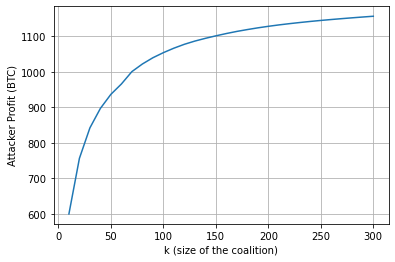

In [37]:
# Attacker Profit - Dynamic Case

LWMC_output_file = open(f"max-cut/weighted-imbalanced-max-cut-output.json", mode = 'r')
LWMC_output_content = LWMC_output_file.read()
LWMC_output_data = json.loads(LWMC_output_content)

k_arr = []
profits = []

attacker_fee_index = 18
i = 0

while(i < len(LWMC_output_data)):
    k = LWMC_output_data[i]["k"]
    print(f"k = {k}")
    attacked_capacity = LWMC_output_data[i]["capacity"]
    attacked_edges = LWMC_output_data[i]["edges"]
    avg_capacity_per_channel = attacked_capacity / attacked_edges
    failed_justice_transactions = simulate(mempool_data, blocks_data, FIRST_BLOCK_HEIGHT, attacker_fee_index, attacked_edges, AVERAGE_LND_CLOSING_CHANNEL_DELAY, dynamic=True, step=6, beta=1.01)
    profit = 0.5 * failed_justice_transactions * avg_capacity_per_channel - (0.5 * (attacked_edges - failed_justice_transactions) * avg_capacity_per_channel)
    profits.append(profit)
    k_arr.append(k)
    i += 1

fig, ax = plt.subplots()
ax.grid(True)
plt.plot(k_arr, profits)   
plt.xlabel('k (size of the coalition)') 
plt.ylabel(f'Attacker Profit (BTC)')
plt.show()
